You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/20
3333/3333 - 9s - loss: 0.0118 - val_loss: 0.0054 - 9s/epoch - 3ms/step
Epoch 2/20
3333/3333 - 5s - loss: 0.0039 - val_loss: 0.0024 - 5s/epoch - 1ms/step
Epoch 3/20
3333/3333 - 5s - loss: 0.0032 - val_loss: 0.0030 - 5s/epoch - 1ms/step
Epoch 4/20
3333/3333 - 5s - loss: 0.0028 - val_loss: 0.0049 - 5s/epoch - 2ms/step
Epoch 5/20
3333/3333 - 5s - loss: 0.0025 - val_loss: 0.0034 - 5s/epoch - 1ms/step
Epoch 6/20
3333/3333 - 5s - loss: 0.0023 - val_loss: 0.0024 - 5s/epoch - 1ms/step
Epoch 7/20
3333/3333 - 5s - loss: 0.0022 - val_loss: 0.0015 - 5s/epoch - 1ms/step
Epoch 8/20
3333/3333 - 5s - loss: 0.0021 - val_loss: 0.0024 - 5s/epoch - 1ms/step
Epoch 9/20
3333/3333 - 5s - loss: 0.0021 - val_loss: 0.0024 - 5s/epoch - 2ms/step
Epoch 10/20
3333/3333 - 5s - loss: 0.0020 - val_loss: 0.0026 - 5s/epoch - 2ms/step
Epoch 11/20
3333/3333 - 6s - l

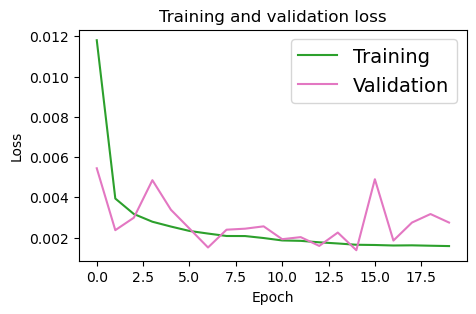

80/80 [==============================] - 0s 882us/step
Anomaly detection ratio:  8.838e-02


C:\Users\gouhe\AppData\Local\Temp\ipykernel_28032\3444304767.py:195: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.2)


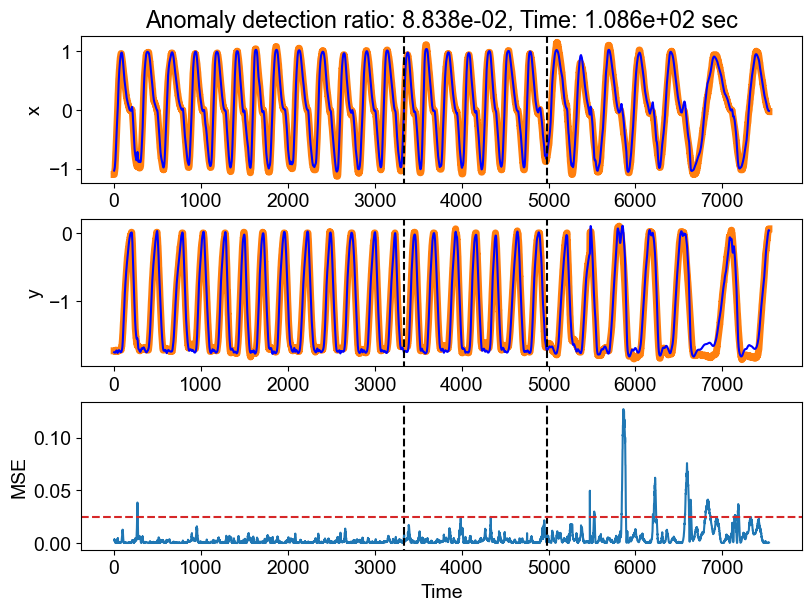

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

########################################
# LSTM-based anomaly detection for handwritten triangle data
#
# The model is trained with a part of InoueI data, validated with 
# the remaining data from InoueI, and then tested with InoueH data.
#
# (c) Gouhei Tanaka
########################################

import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
from scipy import optimize
from tensorflow.keras.utils import plot_model


if __name__ == '__main__':

    # read data (InoueI)
    data_i = np.empty([0,3])
    count_i = 0
    for n in range(7):
        df = pd.read_csv('./InoueI/inouei_'+str(n)+'.csv', header=0, delimiter=',')
        #print(df.shape)
        count_i += df.shape[0]
        #print(count_i)
        data_i = np.vstack((data_i, df))
    #print(data_i)
    #print(data_i.shape)

    data_i_x = data_i[:,1]/100
    data_i_x = data_i_x.reshape(len(data_i_x), -1)
    data_i_y = data_i[:,2]/100
    data_i_y = data_i_y.reshape(len(data_i_y), -1)

    #scaler = StandardScaler()
    #std_data_i_x = scaler.fit_transform(data_i_x)
    #std_data_i_y = scaler.fit_transform(data_i_y)

    # read data (InoueH)
    data_h = np.empty([0,3])
    count_h = 0
    for n in range(20):
        df = pd.read_csv('./InoueH/inoueH_'+str(n)+'.csv', header=0, delimiter=',')
        #print(df.shape)
        count_h += df.shape[0]
        #print(count_h)
        data_h = np.vstack((data_h, df))
    #print(data_h)
    #print(data_h.shape)

    data_h_x = data_h[:,1]/100
    data_h_x = data_h_x.reshape(len(data_h_x), -1)
    data_h_y = data_h[:,2]/100
    data_h_y = data_h_y.reshape(len(data_h_y), -1)

    #scaler = StandardScaler()
    #std_data_h_x = scaler.fit_transform(data_h_x)
    #std_data_h_y = scaler.fit_transform(data_h_y)

    # concatenate two data without scaling
    data_x = np.concatenate((data_h_x, data_i_x))
    data_y = np.concatenate((data_h_y, data_i_y))

    # all data
    index_min = 0
    index_max = count_i +  count_h
    lookback = 100
    pred_len = 1

    U = np.empty([index_max-index_min-lookback-pred_len,0], dtype=float)
    D = np.empty([index_max-index_min-lookback-pred_len,0], dtype=float)

    for i in range(lookback):
        data_x_tmp = data_x[index_min+i:index_max-pred_len-lookback+i].reshape(-1,1)
        data_y_tmp = data_y[index_min+i:index_max-pred_len-lookback+i].reshape(-1,1)
        U = np.concatenate([U, data_x_tmp, data_y_tmp], axis=1)

    for j in range(pred_len):
        data_x_tmp = data_x[index_min+lookback+j:index_max-pred_len+j].reshape(-1,1)
        data_y_tmp = data_y[index_min+lookback+j:index_max-pred_len+j].reshape(-1,1)
        D = np.concatenate([D, data_x_tmp, data_y_tmp], axis=1)

    # data separation
    U = np.reshape(U, (U.shape[0], 1, U.shape[1]))

    len_train = 3333
    len_val = count_h-3333
    len_test = U.shape[0]-len_train-len_val

    U_train = U[:len_train,:,:]
    U_val = U[len_train:len_train+len_val,:,:]
    U_test = U[len_train+len_val:len_train+len_val+len_test,:,:]
    D_train = D[:len_train,:]
    D_val = D[len_train:len_train+len_val,:]
    D_test = D[len_train+len_val:len_train+len_val+len_test,:]

    # model
    model = Sequential()
    model.add(layers.LSTM(20, activation='tanh', input_shape=(None,U_train.shape[-1])))
    model.add(layers.Dense(D_train.shape[-1]))

    model.compile(optimizer=RMSprop(), loss='mse')
    #model.compile(optimizer=Adam(lr=learning_rate), loss='mse')
    
    plot_model(model, show_shapes=True, show_layer_names=False)
    
    time_start = time.time()

    #history = model.fit(U_train, D_train, epochs=50, batch_size=1, verbose=2)
    history = model.fit(U_train, D_train, epochs=20, batch_size=1, validation_data=(U_val, D_val), verbose=2)

    time_end = time.time()
    time_learning = time_end-time_start
    time_learning = '{0:.3e}'.format(time_learning)
    print('Time for training: ', time_learning)
    
    # loss
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    
    plt.figure(figsize=(5,3))
    plt.plot(epochs, loss, 'tab:green', label='Training')
    plt.plot(epochs, val_loss, 'tab:pink', label="Validation")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title("Training and validation loss")
    plt.legend(fontsize=14)
    plt.show()
    #plt.savefig('test_loss.eps', bbox_inches="tight")
    #plt.savefig('test_loss.png', bbox_inches="tight")

    # model outputs
    Y_train = model.predict(U_train)
    Y_val = model.predict(U_val)
    Y_test = model.predict(U_test)

    Y = np.vstack((Y_train, Y_val))
    Y = np.vstack((Y, Y_test))

    # error evaluation
    mse_all = []
    rmse_all = []
    mae_all = []
    for i in range(D.shape[0]):
        mse = ((D[i,0] - Y[i,0])**2+(D[i,1]-Y[i,1])**2)/2
        mse_all.append(mse)
        rmse_all.append(np.sqrt(mse))
        mae_all.append(np.abs(D[i,0] - Y[i,0]))

    mse_val = []
    rmse_val = []
    mae_val = []
    mse_val_max = 0.0
    for i in range(D_val.shape[0]):
        mse = ((D_val[i,0] - Y_val[i,0])**2+(D_val[i,1]-Y_val[i,1])**2)/2
        mse_val.append(mse)
        rmse_val.append(np.sqrt(mse))
        mae_val.append(np.abs(D_val[i,0] - Y_val[i,0]))
        if mse > mse_val_max:
            mse_val_max = mse
            #print(i, mse_val_max)

    mse_test = []
    rmse_test = []
    mae_test = []
    count_a = 0
    for i in range(D_test.shape[0]):
        mse = ((D_test[i,0] - Y_test[i,0])**2+(D_test[i,1]-Y_test[i,1])**2)/2
        mse_test.append(mse)
        rmse_test.append(np.sqrt(mse))
        mae_test.append(np.abs(D_test[i,0] - Y_test[i,0]))
        if mse >= mse_val_max:
            count_a += 1
    adr = count_a/D_test.shape[0]
    adr = '{0:.3e}'.format(adr)
    print('Anomaly detection ratio: ', adr)
    
    # draw
    plt.rcParams['font.size'] = 14
    plt.rcParams['font.family'] = 'Arial'
    fig, ax = plt.subplots(3, 1, figsize=(8,6), constrained_layout=True)
    plt.subplots_adjust(hspace=0.2)

    ax[0].plot(D[:,0], color='tab:orange', linewidth=5, label = 'Target')
    ax[0].plot(Y[:,0], color='blue', label = 'Prediction')
    ax[0].axvline(x=len_train, ymin=-1, ymax=1, linestyle='--', color='black')
    ax[0].axvline(x=len_train+len_val, ymin=-1, ymax=1, linestyle='--', color='black')
    ax[0].set_ylabel('x')
    ax[0].set_title('Anomaly detection ratio: '+str(adr)+', Time: '+str(time_learning)+' sec')
    #ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    #ax[0].legend(loc='best')

    ax[1].plot(D[:,1], color='tab:orange', linewidth=5, label = 'Target')
    ax[1].plot(Y[:,1], color='blue', label = 'Prediction')
    ax[1].axvline(x=len_train, ymin=-2, ymax=1, linestyle='--', color='black')
    ax[1].axvline(x=len_train+len_val, ymin=-2, ymax=1, linestyle='--', color='black')
    ax[1].set_ylabel('y')
    #ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    #ax[1].legend(loc='best')

    ax[2].plot(mse_all, '-')
    #ax[2].plot(mae_all, label='MAE')
    #ax[2].plot(rmse_all, label='RMSE')
    ax[2].set_ylabel('MSE')
    #ax[2].set_ylim([0, 0.02])
    ax[2].axvline(x=len_train, ymin=-2, ymax=1, linestyle='--', color='black')
    ax[2].axvline(x=len_train+len_val, ymin=-2, ymax=1, linestyle='--', color='black')
    #ax[2].axvline(x=3333+1390, ymin=-2, ymax=1, linestyle='--', color='tab:pink')
    ax[2].axhline(y=mse_val_max, xmin=0, xmax=D.shape[0], linestyle='--', color='tab:red')
    ax[2].set_xlabel('Time')

    plt.show()